# 03 - Data Summary Stats



## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import datetime as dt

import sys

sys.path.append('../')
import src

# sys.path.append('../../kungfu/')
# import kungfu as kf

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#### Assets

In [3]:
%%time
df_stats = pd.DataFrame()
for year in range(1994, 2020):
    for month in range(1, 12+1):
        df_back = src.loader.load_monthly_crsp(year, month, which='back')
        df_back['retadj'] = (df_back['retadj'].unstack() - src.loader.load_rf(year=year, month=month, which='back').values).stack()
        sampling_date = df_back.unstack().index[-1]
        n_months = len(df_back.unstack().index.to_period('M').unique())
        
        # estimate
        back_stats = src.utils.summarise_returns(df_back)
        back_stats.index = pd.MultiIndex.from_product([[sampling_date], back_stats.index], names=['sampling_date', 'permno'])
        back_stats.columns = [column+'_back_{}M'.format(n_months) for column in back_stats.columns]
       
        ## forward part
        df_forward = src.loader.load_monthly_crsp(year, month, which='forward')
        df_forward['retadj'] = (df_forward['retadj'].unstack() - src.loader.load_rf(year=year, month=month, which='forward').values).stack()
        months = df_forward.unstack().index.to_period('M').unique().tolist()
        
        # estimate
        forward_stats = pd.DataFrame(index=back_stats.index)
        for i in range(1, len(months)+1):
            data = (df_forward.unstack()[df_forward.unstack().index.to_period('M').isin(months[:i])]).stack()
            month_stats = src.utils.summarise_returns(data)
            month_stats.index = pd.MultiIndex.from_product([[sampling_date], month_stats.index], names=['sampling_date', 'permno'])
            month_stats.columns = [column+'_forward_{}M'.format(i) for column in month_stats.columns]
            forward_stats = forward_stats.join(month_stats)
                
        # combine
        stats = back_stats.join(forward_stats)
        df_stats = df_stats.append(stats)
    print('Done estimating year {}'.format(year))
        
    df_stats.to_csv('../data/estimated/summary_stats.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997
Done estimating year 1998
Done estimating year 1999
Done estimating year 2000
Done estimating year 2001
Done estimating year 2002
Done estimating year 2003
Done estimating year 2004
Done estimating year 2005
Done estimating year 2006
Done estimating year 2007
Done estimating year 2008
Done estimating year 2009
Done estimating year 2010
Done estimating year 2011
Done estimating year 2012
Done estimating year 2013
Done estimating year 2014
Done estimating year 2015
Done estimating year 2016
Done estimating year 2017
Done estimating year 2018
Done estimating year 2019
CPU times: user 14min 49s, sys: 17.2 s, total: 15min 7s
Wall time: 15min 29s


#### SPY

In [4]:
spy = src.loader.load_spy()
spy.index = spy.index.to_period('M')
spy_ret = spy['ret'].groupby('date').apply(lambda x: (1+x).prod()-1)
spy_ret

date
1993-01    0.000000
1993-02    0.010669
1993-03    0.017593
1993-04   -0.025588
1993-05    0.026969
             ...   
2020-08    0.069797
2020-09   -0.037398
2020-10   -0.024934
2020-11    0.108777
2020-12    0.037066
Freq: M, Name: ret, Length: 336, dtype: float64

In [58]:
%%time
spy = src.loader.load_spy()
spy_stats = pd.DataFrame()
for year in range(1994, 2020):
    for month in range(1, 12+1):
        back_dates = src.loader.load_monthly_crsp(year, month, which='back').index.get_level_values('date').unique()
        sampling_date = back_dates[-1]
        n_months = len(back_dates.to_period('M').unique())
        
        # estimate
        back_spy = spy.loc[spy.index.isin(back_dates), 'ret']
        stats = pd.DataFrame(data = back_spy.agg([lambda x: (1+x).prod()-1, lambda x: x.var()*252]).values.reshape(1, -1),
                                  index=[sampling_date],
                                  columns=['ret', 'var'])
        stats.columns = [column+'_back_{}M'.format(n_months) for column in stats.columns]
       
        ## forward part
        forward_dates = src.loader.load_monthly_crsp(year, month, which='forward').index.get_level_values('date').unique()
        months = forward_dates.to_period('M').unique().tolist()
        
        # estimate
        forward_stats = pd.DataFrame(index=back_stats.index)
        for i in range(1, len(months)+1):
            months_spy = spy.loc[spy.index.to_period('M').isin(months[:i]), 'ret']
            stats['ret_forward_{}M'.format(i)] = (1+months_spy).prod()-1
            stats['var_forward_{}M'.format(i)] = months_spy.var()*252
            
        # combine
        spy_stats = spy_stats.append(stats)
    print('Done estimating year {}'.format(year))
        
    spy_stats.to_csv('../data/estimated/spy_stats.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997
Done estimating year 1998
Done estimating year 1999
Done estimating year 2000
Done estimating year 2001
Done estimating year 2002
Done estimating year 2003
Done estimating year 2004
Done estimating year 2005
Done estimating year 2006
Done estimating year 2007
Done estimating year 2008
Done estimating year 2009
Done estimating year 2010
Done estimating year 2011
Done estimating year 2012
Done estimating year 2013
Done estimating year 2014
Done estimating year 2015
Done estimating year 2016
Done estimating year 2017
Done estimating year 2018
Done estimating year 2019
CPU times: user 1min 5s, sys: 20.4 s, total: 1min 25s
Wall time: 1min 51s


In [4]:
%%time
df_stats = pd.DataFrame()
for year in range(1994, 2020):
    for month in range(1, 12+1):
        ## backwards part
        df_back = src.loader.load_monthly_crsp(year, month, which='back', column='retadj')
        sampling_date = df_back.index[-1]
        n_months = len(df_back.index.to_period('M').unique())
        
#         # estimate
#         back_estimates = src.factor.estimate_models(df_back, ret_models)
#         back_estimates.index = pd.MultiIndex.from_product([[sampling_date], back_estimates.index], names=['sampling_date', 'permno'])
#         back_estimates.columns = [column+'_back_{}M'.format(n_months) for column in back_estimates.columns]
       
#         ## forward part
#         df_forward = src.loader.load_month(year, month, which='forward', column='retadj')
#         months = df_forward.index.to_period('M').unique().tolist()
        
#         # estimate
#         forward_estimates = pd.DataFrame(index=back_estimates.index)
#         for i in range(1, len(months)+1):
#             data = df_forward[df_forward.index.to_period('M').isin(months[0:i])]
#             month_estimates = src.factor.estimate_models(data, ret_models)
#             month_estimates.index = pd.MultiIndex.from_product([[sampling_date], month_estimates.index], names=['sampling_date', 'permno'])
#             month_estimates.columns = [column+'_forward_{}M'.format(i) for column in month_estimates.columns]
#             forward_estimates = forward_estimates.join(month_estimates)
                
#         # combine
#         estimates = back_estimates.join(forward_estimates)
#         df_estimates = df_estimates.append(estimates)
    print('Done estimating year {}'.format(year))
        
    df_stats.to_csv('../data/estimated/summary_stats.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997
Done estimating year 1998
Done estimating year 1999
Done estimating year 2000
Done estimating year 2001
Done estimating year 2002
Done estimating year 2003
Done estimating year 2004
Done estimating year 2005
Done estimating year 2006
Done estimating year 2007
Done estimating year 2008
Done estimating year 2009
Done estimating year 2010
Done estimating year 2011
Done estimating year 2012
Done estimating year 2013
Done estimating year 2014
Done estimating year 2015
Done estimating year 2016
Done estimating year 2017
Done estimating year 2018
Done estimating year 2019
CPU times: user 14.1 s, sys: 5.17 s, total: 19.3 s
Wall time: 32.4 s


## Process all years

In [13]:
df_stats = pd.DataFrame()
for year in range(1960, 2020):
    returns = kf.FinancialDataFrame(src.loader.load_year(year, data='returns', data_year=year))
    if year != 2019:
        next_returns = kf.FinancialDataFrame(src.loader.load_year(year, data='returns', data_year=year+1))
        first_quarter = next_returns[next_returns.index.quarter==1]
        first_month = next_returns[next_returns.index.month==1]
    
    year_stats = returns.summarise_performance(annual_obs=252).T
    year_stats.columns = [col+' (t)' for col in year_stats.columns]
    if year != 2019:
        next_year_stats = next_returns.summarise_performance(annual_obs=252).T
        next_year_stats.columns = [col+' (t+1)' for col in next_year_stats.columns]
        year_stats = year_stats.join(next_year_stats)
        
        first_quarter_stats = first_quarter.summarise_performance(annual_obs=252).T
        first_quarter_stats.columns = [col+' (3M)' for col in first_quarter_stats.columns]
        year_stats = year_stats.join(first_quarter_stats)
        
        first_month_stats = first_month.summarise_performance(annual_obs=252).T
        first_month_stats.columns = [col+' (1M)' for col in first_month_stats.columns]
        year_stats = year_stats.join(first_month_stats)
        
    year_stats.index = pd.MultiIndex.from_product([[year], year_stats.index], names=['sampling_year', 'permno'])
    
    # collect
    df_stats = df_stats.append(year_stats)
    
    # progress
    print('processed sampling year {}'.format(year))
    
df_stats.to_csv('../data/estimated/summary_stats.csv')

processed sampling year 1993
processed sampling year 1994
processed sampling year 1995
processed sampling year 1996
processed sampling year 1997
processed sampling year 1998
processed sampling year 1999
processed sampling year 2000
processed sampling year 2001
processed sampling year 2002
processed sampling year 2003
processed sampling year 2004
processed sampling year 2005
processed sampling year 2006
processed sampling year 2007
processed sampling year 2008
processed sampling year 2009
processed sampling year 2010
processed sampling year 2011
processed sampling year 2012
processed sampling year 2013
processed sampling year 2014
processed sampling year 2015
processed sampling year 2016
processed sampling year 2017
processed sampling year 2018
processed sampling year 2019


In [3]:
df_stats.columns

NameError: name 'df_stats' is not defined

In [124]:
_ = load_month(2019, 12, which='back', column=None)
_[_.index.get_level_values('date')=='2019-12-31'].sort_values('mcap', ascending=False).tail(20)

ticker          mcap       var      noisevar    retadj
date       permno                                                       
2019-12-31 71563     TFC  7.554399e+07  0.000006  2.146873e-09 -0.001772
           93436    TSLA  7.540189e+07  0.000148  1.882859e-08  0.008753
           44644     ADP  7.377501e+07  0.000005  3.744054e-09  0.005366
           39642     BDX  7.355701e+07  0.000010  4.510900e-09  0.005360
           40539     TJX  7.346642e+07  0.000006  1.825025e-09 -0.001798
           89626     CME  7.193022e+07  0.000011  1.368153e-08  0.007732
           13928     COP  7.135540e+07  0.000026  1.607720e-09  0.006501
           60442     PNC  6.994508e+07  0.000005  4.271921e-09 -0.002437
           88352    ISRG  6.832157e+07  0.000006  2.121459e-08 -0.000287
           78975    INTU  6.818221e+07  0.000013  1.428468e-08 -0.003462
           64936       D  6.816856e+07  0.000006  9.928692e-10  0.009016
           91937    TMUS  6.709419e+07  0.000005  2.766932e-08  0.004354
           27959     DUK  6.683714e+07  0.000003  3.274622e-09  0.004626
           18411      SO  6.680436e+07  0.000005  1.676852e-09  0.005684
           17478    SPGI  6.673342e+07  0.000006  3.287121e-09  0.004082
           49154     TGT  6.496875e+07  0.000011  1.656989e-09 -0.005276
           13788     ZTS  6.303818e+07  0.000005  3.497065e-09  0.001059
           77605     BSX  6.302872e+07  0.000009  3.328097e-09  0.005112
           24942     RTN  6.119298e+07  0.000007  2.386411e-08 -0.002044
           75186    SCHW  6.109458e+07  0.000009  3.008564e-09 -0.005437

In [118]:
_ = load_month(2019, 12, which='back', column='noisevar')
_

permno,10104,10107,10145,10696,11308,11850,12060,12308,12490,13407,...,89626,90215,90319,91233,91937,92602,92611,92655,93002,93436
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,3.328097e-09,6.645389e-10,3.911774e-10,1.305105e-09,3.089908e-09,1.401995e-09,1.051193e-07,1.385745e-08,4.614558e-09,1.478647e-09,...,1.973325e-10,3.334351e-09,2.958778e-09,4.720744e-09,6.387558e-09,1.502916e-09,3.856144e-10,4.584580e-10,3.811488e-09,7.089263e-11
2019-01-03,3.393401e-09,6.458270e-09,3.623560e-09,2.215229e-08,3.128168e-09,1.444804e-09,1.048585e-07,2.380468e-08,4.798561e-09,1.561526e-09,...,3.303934e-09,6.397333e-09,1.939400e-07,1.014230e-08,6.436780e-09,1.541150e-09,1.035383e-08,9.830285e-09,4.592602e-09,7.510013e-11
2019-01-04,3.115088e-09,6.550186e-10,1.501963e-09,1.269697e-09,3.009594e-09,1.344657e-09,1.005495e-07,1.068391e-08,7.911496e-09,3.572330e-10,...,4.985636e-09,3.218370e-09,2.832321e-09,1.893510e-10,1.343936e-08,5.631393e-09,3.428321e-09,1.185492e-10,3.204847e-08,1.139737e-08
2019-01-07,3.019987e-09,2.612179e-09,3.709274e-10,5.096472e-09,3.088315e-09,1.330035e-09,8.916799e-08,9.063496e-09,4.875241e-10,3.568189e-10,...,5.039312e-09,3.373171e-10,4.865065e-08,1.862364e-10,1.453261e-09,1.496682e-09,3.304010e-09,1.888860e-09,1.923308e-09,1.552996e-08
2019-01-08,2.965992e-09,6.438539e-10,3.737710e-10,1.258671e-09,3.019987e-09,1.308908e-09,9.272507e-08,2.439860e-08,4.262674e-09,5.358274e-09,...,7.342394e-09,2.881084e-09,2.077716e-08,1.838196e-10,1.333642e-08,5.912693e-09,3.272239e-09,4.601403e-10,1.219789e-10,5.445551e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,2.382792e-09,2.743537e-10,1.968996e-09,4.505142e-09,2.273461e-09,1.388015e-09,5.437257e-08,6.621557e-09,3.361086e-09,1.034497e-08,...,1.052477e-08,1.021411e-09,1.688971e-08,2.766621e-09,1.819895e-08,3.667929e-09,3.092214e-09,2.821928e-09,6.636209e-11,3.048529e-09
2019-12-26,2.370319e-09,2.699450e-10,1.956771e-09,2.020986e-09,2.247836e-09,1.381948e-09,5.398575e-08,1.153887e-08,3.363079e-09,3.940227e-09,...,6.038780e-09,1.004536e-09,1.645570e-08,1.093744e-08,1.136252e-09,9.194963e-10,1.711505e-09,7.003613e-10,6.056828e-10,3.665011e-09
2019-12-27,2.381010e-09,2.697828e-10,5.457919e-09,4.965603e-10,2.220303e-09,1.393183e-09,5.448032e-08,1.161837e-10,3.713662e-10,2.512965e-09,...,5.957447e-09,6.251394e-09,3.714651e-12,7.520812e-09,1.140669e-09,3.656279e-09,9.291277e-09,1.521149e-08,6.803722e-11,8.267414e-09


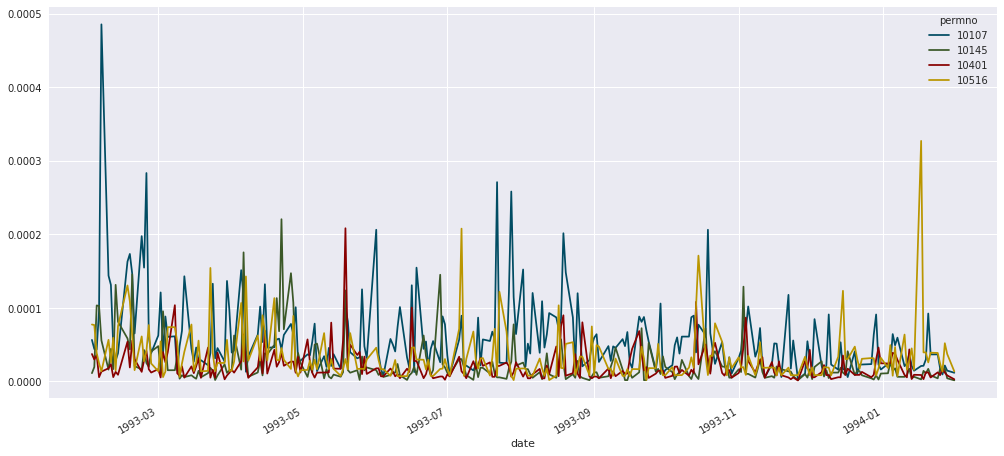

In [54]:
df = load_month(1994, 1)
df['var'].unstack().iloc[:,1:5].plot()

## Summary Stats

In [4]:
def summarise_returns(df, annual_obs=252):
    fdf = kf.FinancialDataFrame(df)
    stats = fdf.summarise_performance(annual_obs=annual_obs).T
    stats = stats.rename(columns={'Return p.a. (arithmetic)': 'ret_pa_arithmetic',
                                  'Return p.a. (geometric)': 'ret_pa_geometric',
                                  'Volatility p.a.': 'vola_pa',
                                  'Sharpe ratio': 'sharpe_ratio',
                                  't-stat': 't_stat',
                                  'Total return': 'ret_total',
                                  'Positive returns %': 'positive_pct',
                                  'VaR 95% (historic)': 'var_95_historic',
                                  'VaR 95% (parametric)': 'var_95_parametric',
                                  'Expected shortfall 95%': 'es_95',
                                  'Downside volatility': 'down_vola_pa',
                                  'Maximum drawdown': 'max_drawdown',
                                 })
    return stats

In [5]:
df_summary = pd.DataFrame()

In [6]:
%%time
for year in range(1994, 2020):
    for month in range(1, 12+1):
        ## backwards part
        df_back = src.loader.load_month(year, month, which='back', column='retadj')
        sampling_date = df_back.index[-1]
        n_months = len(df_back.index.to_period('M').unique())
        
        # estimate
        back_stats = summarise_returns(df_back)
        back_stats.index = pd.MultiIndex.from_product([[sampling_date], back_stats.index], names=['sampling_date', 'permno'])
        back_stats.columns = [column+'_back_{}M'.format(n_months) for column in back_stats.columns]
       
        ## forward part
        df_forward = src.loader.load_month(year, month, which='forward', column='retadj')
        months = df_forward.index.to_period('M').unique().tolist()
        
        # estimate
        forward_stats = pd.DataFrame(index=back_stats.index)
        for i in range(1, len(months)+1):
            data = df_forward[df_forward.index.to_period('M').isin(months[0:i])]
            month_stats = summarise_returns(data)
            month_stats.index = pd.MultiIndex.from_product([[sampling_date], month_stats.index], names=['sampling_date', 'permno'])
            month_stats.columns = [column+'_forward_{}M'.format(i) for column in month_stats.columns]
            forward_stats = forward_stats.join(month_stats)
                
        # combine
        stats = back_stats.join(forward_stats)
        df_summary = df_summary.append(stats)
    print('Done estimating year {}'.format(year))
        
    df_summary.to_csv('../data/estimated/return_summary.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997


TypeError: only size-1 arrays can be converted to Python scalars